In [21]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Reshape, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPool2D, LeakyReLU, Flatten
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [2]:
tf.__version__

'2.6.0'

In [3]:
(train_images,_),(_,_) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

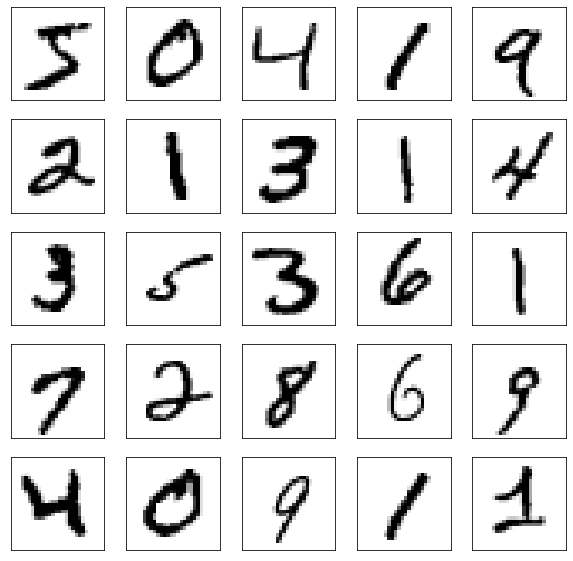

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].squeeze(), cmap=plt.cm.binary)
plt.show()

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def create_generator():

    generator = Sequential()
    generator.add(Dense(7*7*256,input_shape=(100,),use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Reshape((7,7,256)))
    generator.add(Conv2DTranspose(128,5,1,padding='same',use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(64,5,2,padding='same',use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(1,5,2,padding='same',activation='tanh',use_bias=False))

    return generator


In [9]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64,4,2,padding='same',input_shape=(28,28,1)))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128,4,2,padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    
    discriminator.add(Dense(1))

    return discriminator

In [55]:
class GAN():
    def __init__(self):
        self.generator = create_generator()
        self.discriminator = create_discriminator()
        self.loss = keras.losses.BinaryCrossentropy(from_logits=True)
        self.epochs = 25
        self.noise_dim = 100
        self.generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)

    def discriminator_loss(self,real_outputs,fake_outputs):
        real_loss = self.loss(tf.ones_like(real_outputs),real_outputs)
        fake_loss = self.loss(tf.zeros_like(fake_outputs),fake_outputs)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self,fake_outputs):
        return self.loss(tf.ones_like(fake_outputs),fake_outputs)

    
    @tf.function
    def train_step(self,images):
        noise = tf.random.normal([BATCH_SIZE,self.noise_dim])
    
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise,training=True)

            real_outputs = self.discriminator(images,training=True)
            fake_outputs = self.discriminator(generated_images,training=True)

            gen_loss = self.generator_loss(fake_outputs)
            disc_loss = self.discriminator_loss(real_outputs,fake_outputs)

        generator_gradients = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(generator_gradients,self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients,self.discriminator.trainable_variables))

        return gen_loss, disc_loss


    def fit(self,dataset):
        history = {'gen_loss':[],'disc_loss':[]}
        gen_loss=0
        dis_loss=0
        for epoch in range(self.epochs):
            print(f"Epoch:{epoch+1} of {self.epochs} epochs")
            start = time.time()
            for batch in tqdm(dataset):
                gen_loss, disc_loss = self.train_step(batch)
            print(f"Generator loss: {gen_loss},\ndiscriminator_loss: {disc_loss}")
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)

        return history

In [20]:
!nvidia-smi
# physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Sun Sep 26 21:13:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    58W / 149W |   2303MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
gan = GAN()
history = gan.fit(train_dataset)

Epoch:1 of 25 epochs


100%|██████████| 235/235 [00:24<00:00,  9.75it/s]


Generator loss: 0.6828868389129639,
discriminator_loss: 1.3640949726104736
Epoch:2 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.73it/s]


Generator loss: 0.6843820810317993,
discriminator_loss: 1.2962453365325928
Epoch:3 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.67it/s]


Generator loss: 0.6932069659233093,
discriminator_loss: 1.3349480628967285
Epoch:4 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.66it/s]


Generator loss: 0.7470530867576599,
discriminator_loss: 1.3444594144821167
Epoch:5 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.70it/s]


Generator loss: 0.84464430809021,
discriminator_loss: 1.2691926956176758
Epoch:6 of 25 epochs


100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Generator loss: 0.7977044582366943,
discriminator_loss: 1.2373347282409668
Epoch:7 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.60it/s]


Generator loss: 0.9450047612190247,
discriminator_loss: 1.2904362678527832
Epoch:8 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.67it/s]


Generator loss: 0.8611087799072266,
discriminator_loss: 1.3320562839508057
Epoch:9 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.69it/s]


Generator loss: 0.8477194905281067,
discriminator_loss: 1.2624444961547852
Epoch:10 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.68it/s]


Generator loss: 0.738955557346344,
discriminator_loss: 1.3223083019256592
Epoch:11 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.67it/s]


Generator loss: 0.7126583456993103,
discriminator_loss: 1.3321514129638672
Epoch:12 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.70it/s]


Generator loss: 0.673949658870697,
discriminator_loss: 1.26935613155365
Epoch:13 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.71it/s]


Generator loss: 0.7600425481796265,
discriminator_loss: 1.3331522941589355
Epoch:14 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.69it/s]


Generator loss: 0.6255128383636475,
discriminator_loss: 1.5290107727050781
Epoch:15 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.69it/s]


Generator loss: 0.7805262804031372,
discriminator_loss: 1.3426768779754639
Epoch:16 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.66it/s]


Generator loss: 0.8056368827819824,
discriminator_loss: 1.1471965312957764
Epoch:17 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.69it/s]


Generator loss: 0.8276995420455933,
discriminator_loss: 1.1966947317123413
Epoch:18 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.70it/s]


Generator loss: 0.8073912262916565,
discriminator_loss: 1.344167709350586
Epoch:19 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.70it/s]


Generator loss: 0.7980953454971313,
discriminator_loss: 1.1822803020477295
Epoch:20 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.67it/s]


Generator loss: 0.9162634015083313,
discriminator_loss: 1.2479166984558105
Epoch:21 of 25 epochs


100%|██████████| 235/235 [00:21<00:00, 10.70it/s]


Generator loss: 0.9633474349975586,
discriminator_loss: 1.3880836963653564
Epoch:22 of 25 epochs


100%|██████████| 235/235 [00:41<00:00,  5.72it/s]


Generator loss: 0.7867089509963989,
discriminator_loss: 1.2650415897369385
Epoch:23 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.62it/s]


Generator loss: 0.7381775975227356,
discriminator_loss: 1.3137614727020264
Epoch:24 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.67it/s]


Generator loss: 0.7213637828826904,
discriminator_loss: 1.4197875261306763
Epoch:25 of 25 epochs


100%|██████████| 235/235 [00:22<00:00, 10.68it/s]

Generator loss: 0.9228695631027222,
discriminator_loss: 1.3234899044036865


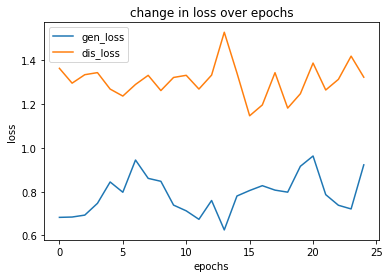

In [60]:
x = [i for i in range(25)]
plt.plot(x,history['gen_loss'])
plt.plot(x,history['disc_loss'])
plt.title('change in loss over epochs')
plt.legend(['gen_loss','dis_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [58]:
noise = np.random.randn(32,100)
pred = gan.generator.predict(noise)

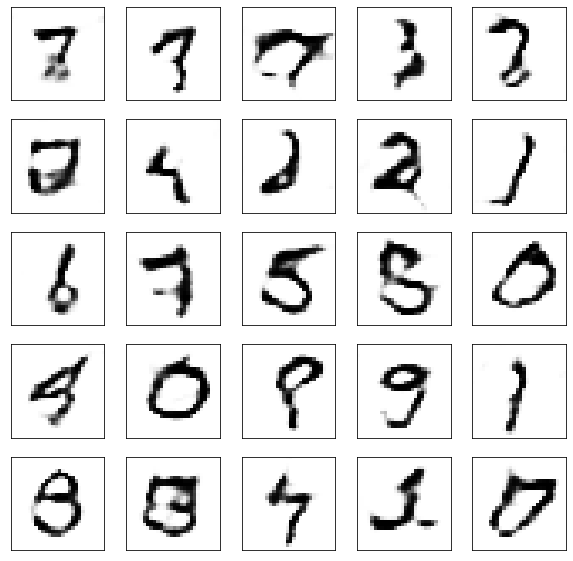

In [59]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(pred[i].squeeze(), cmap=plt.cm.binary)
plt.show()